In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from PIL import Image
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model


In [2]:
#read in csv with captions/image file names
df = pd.read_csv('flickr30k-captions/results.csv', delimiter = '|')
df.head(10)

image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   
5    10002456.jpg              0   
6    10002456.jpg              1   
7    10002456.jpg              2   
8    10002456.jpg              3   
9    10002456.jpg              4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
5   Several men in hard hats are operating a gian...  
6   Workers look down from up above on a piece of...  
7   Two men working on a machine wearing hard hats .  
8              Four men on top of a tall structure .  
9                         Three men on a large rig .

In [3]:
#function to read image in from path and return as numpy array
def process_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img /= 255
    return img

#function to read in all images listed in a dataframe
def get_images(df, directory):
    images = df['image_name'].values 
    images_array = []

    for img_name in images:
        filename = f'{directory}/{img_name}'
        images_array.append(process_image(filename))
                        
    return np.asarray(images_array)

Text(0.5, 1.0, ' Several men are walking and standing in John A. Noble facility .')

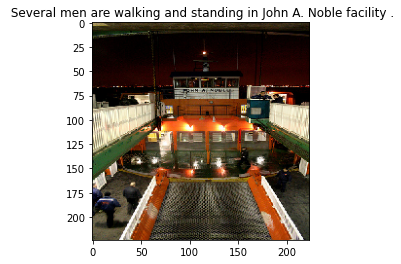

In [7]:
#display random image along with caption

num = random.randint(0, len(df)-1)

pic = process_image(f'flickr30k-images/{df.image_name[num]}')
plt.imshow(pic)
plt.title(df.comment[num])

In [4]:
image_data = get_images(df, 'flickr30k-images')

In [5]:
np.save('image_data.npy', image_data)

In [ ]:
#run this one if image data already saved on your device to save time
image_data = np.load('image_data.npy')

In [ ]:
#set max number of words for tokenizer (keeps only the x most common words)
max_words = 10000

#apply start and end tags to each caption
df['comment'] = df['comment'].astype(str)
df['processed_captions'] = df['comment'].apply(lambda x: '<start> ' + x + ' <end>') 

#create tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<oov>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~\n')

#fit tokenizer onto processed captions and get tokenized sequences
tokenizer.fit_on_texts(df['processed_captions'])
word_to_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['processed_captions'])

#find length of longest caption and pad other captions to match
longest = max([len(caption) for caption in sequences]) 
captions_padded = pad_sequences(sequences, maxlen=longest, padding='post')

df['sequences'] = captions_padded.tolist()

In [ ]:
print(df['sequences'])

In [ ]:
#train test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#data generator to train/test model
def data_generator(df, image_data, batch_size=32, max_vocab=10000):
    while True:
        indices = np.arange(len(df))
        np.random.shuffle(indices)
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_df = df.iloc[batch_indices]

            img_2_arrs, one_hot_captions = [], []

            for _, row in batch_df.iterrows():
                img_index = df.index.get_loc(row.name)
                img_2_arr = image_data[img_index]

                one_hot_caption = to_categorical(row['sequences'], num_classes=max_vocab)
                
                img_2_arrs.append(img_2_arr)
                one_hot_captions.append(one_hot_caption)

            yield np.array(img_2_arrs), np.array(one_hot_captions)

In [ ]:
#extract train and test image data
train_image_data = image_data[train_df.index]
test_image_data = image_data[test_df.index]

In [ ]:
train_data_gen = data_generator(train_df, train_image_data, batch_size=32, max_vocab=10000)
test_data_gen = data_generator(test_df, test_image_data, batch_size=32, max_vocab=10000)

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception

model = models.Sequential()

# using pretrained Xception model
model.add(Xception(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling="max"))
model.add(layers.Dense(256, activation='relu'))

max_len = longest
max_vocab = max_words
model.add(layers.RepeatVector(max_len))
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(max_vocab, activation='softmax')))

#summary
model.summary()

In [ ]:
checkpoint = ModelCheckpoint("new_checkpoint_model_{epoch:02d}.hdf5", monitor='loss', verbose=1,
    save_best_only=False, mode='auto', period=10)
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy")

In [ ]:
model.load_weights('lotsofepochs1.h5')
history = model.fit(train_data_gen, 
                    epochs=80,
                    steps_per_epoch=100,
                    verbose=1, 
                    callbacks=[checkpoint, earlystopping]
                   )

In [46]:
model.save('lotsofepochs2.keras')

In [20]:
from keras.models import load_model
model_new = load_model("lotsofepochs2.keras")

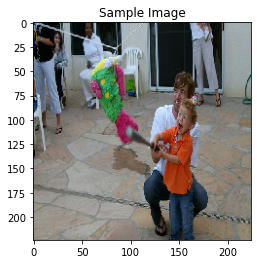

Predicted Caption: <start> a little girl a a a a a a                                                                      
Actual Caption: <start> a child at a party swings a bat at a pinata <oov> by a father <end>



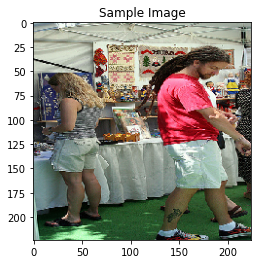

Predicted Caption: <start> a man in a a a a a a                                                                      
Actual Caption: <start> a woman looking at <oov> at a booth at an outdoor fair <end>



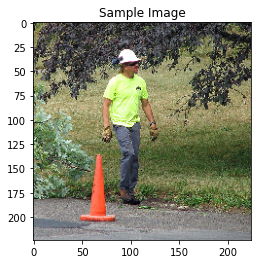

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> a road worker in green there is an orange cone near him <end>



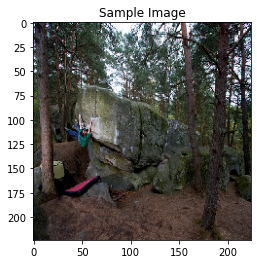

Predicted Caption: <start> a man is a a a a a                                                                       
Actual Caption: <start> a large rock formation in the middle of a forest <end>



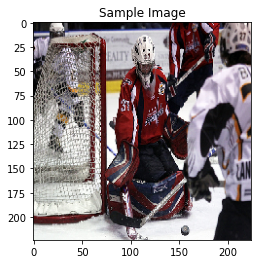

Predicted Caption: <start> a people in a a a a                                                                        
Actual Caption: <start> a goalie tries to block the puck in a hockey game <end>



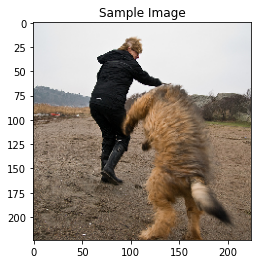

Predicted Caption: <start> a man is a a a a a                                                                       
Actual Caption: <start> a person throws an object as a furry dog jumps to chase it <end>



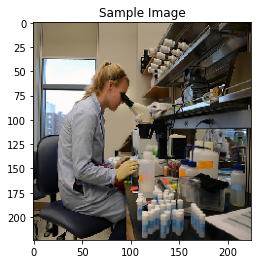

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> the woman in the lab coat is using the microscope <end>



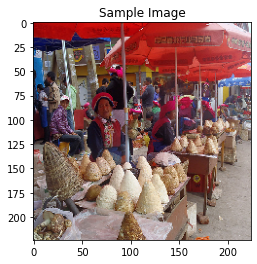

Predicted Caption: <start> a group of people a a a                                                                        
Actual Caption: <start> asian street vendors waiting to sell there merchandise <end>



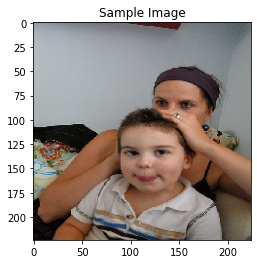

Predicted Caption: <start> a young girl a a a a a                                                                       
Actual Caption: <start> a woman picking through her child 's hair <end>



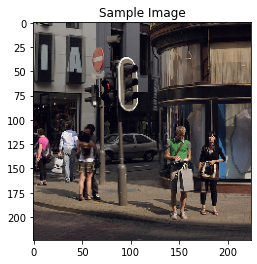

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> a man wearing a green shirt and carrying a shopping bag is reading the newspaper on a city corner while a woman looks on <end>



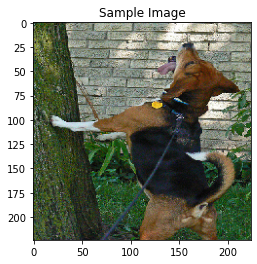

Predicted Caption: <start> a dog dog is a a a <end>                                                                       
Actual Caption: <start> a dog looking up a tree with his tongue hanging out <end>



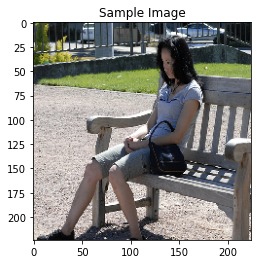

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> a woman with a handbag is sitting on a wooden bench <end>



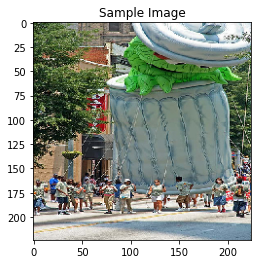

Predicted Caption: <start> a group of people in a a a                                                                       
Actual Caption: <start> there is a parade going on in the street a group of people are holding up an oscar the grouch float device <end>



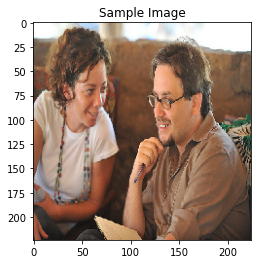

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> woman smiling and looking a man while he is looking in a book smiling <end>



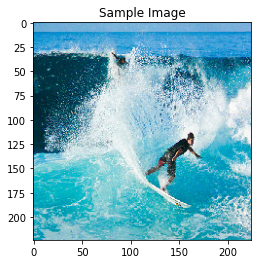

Predicted Caption: <start> a man in a a a a                                                                        
Actual Caption: <start> two people are surfing in the ocean <end>



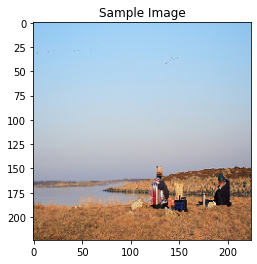

Predicted Caption: <start> a people are a a a a a                                                                       
Actual Caption: <start> two men sitting on the bank of a lake with an ice chest <end>



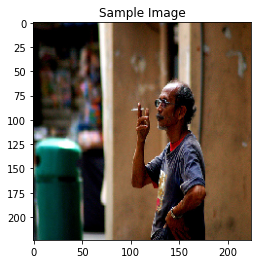

Predicted Caption: <start> a woman in a a a a a                                                                       
Actual Caption: <start> a man in a blue shirt is standing outside smoking a cigarette <end>



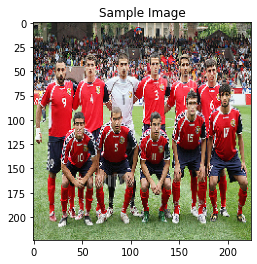

Predicted Caption: <start> a group of in in a                                                                         
Actual Caption: <start> a group of players on a team are posing together <end>



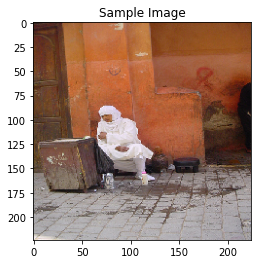

Predicted Caption: <start> a man is a a a a a                                                                       
Actual Caption: <start> a man wearing white site beside a building <end>



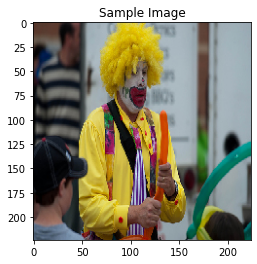

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> a clown with a yellow wig and shirt and multicolored suspenders holds an orange balloon in both hands while a child in a black hat looks on <end>



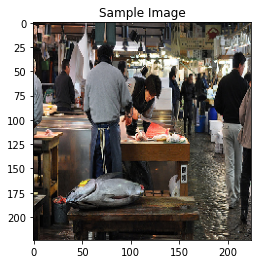

Predicted Caption: <start> a man of a a a a                                                                        
Actual Caption: <start> customers buy cut raw fish at the market <end>



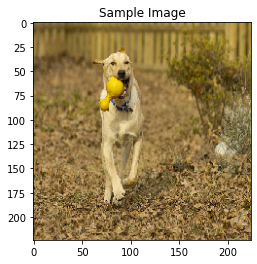

Predicted Caption: <start> a dog dog is dog a a a                                                                       
Actual Caption: <start> dog trotting with a rubber duck in its mouth <end>



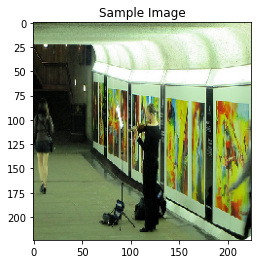

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> a woman dressed in black is playing the violin in front of some artwork <end>



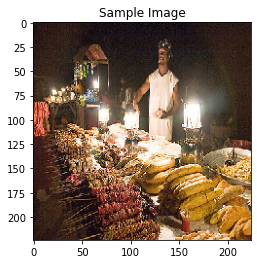

Predicted Caption: <start> a men are a a a a                                                                        
Actual Caption: <start> a man selling food on the streets during late night with three lamps <end>



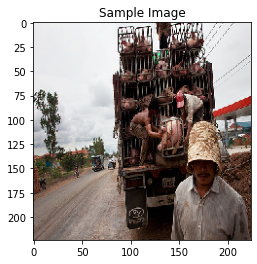

Predicted Caption: <start> two men in a a a a a                                                                       
Actual Caption: <start> asian men are packing pigs onto a truck as people drive by in their carts and scooters <end>



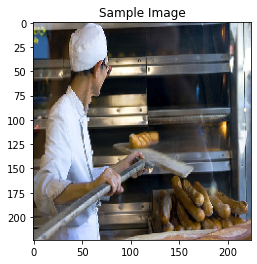

Predicted Caption: <start> a man in a a a a a                                                                       
Actual Caption: <start> man removing bread from an oven <end>



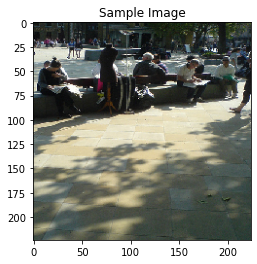

Predicted Caption: <start> a man is a a a a a                                                                       
Actual Caption: <start> a black dress mannequin with a wooden leg stand positioned next to a suitcase and a female dressed in a gray sweater and black pants reading a newspaper in a crowded city square <end>



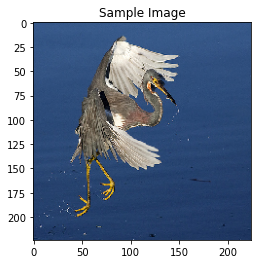

Predicted Caption: <start> a dog dog is a the <end>                                                                        
Actual Caption: <start> a large gray and white bird begins to take flight <end>



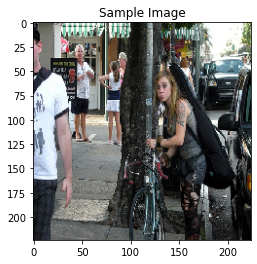

Predicted Caption: <start> a man in a a a a a a                                                                      
Actual Caption: <start> a woman with tattoos and ripped stockings is <oov> her bicycle from a pole <end>



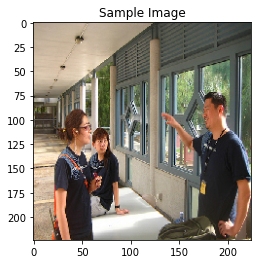

Predicted Caption: <start> two man and a a a a a                                                                       
Actual Caption: <start> a man is talking to two women <end>



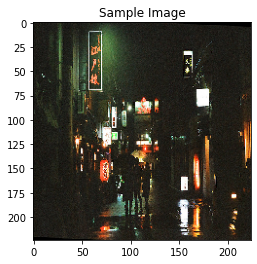

Predicted Caption: <start> a people of a a a a a                                                                       
Actual Caption: <start> the dark streets are wet <end>



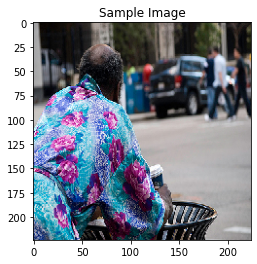

Predicted Caption: <start> a man in a a a a a a                                                                      
Actual Caption: <start> a man in a colorful outfit stands over a trashcan outdoors <end>



In [31]:
imgs, one_hots = next(test_data_gen)
predicted = model_new.predict(imgs)

for i, (img, pred) in enumerate(zip(imgs, predicted)):
    plt.imshow(img)
    plt.title("Sample Image")
    plt.show()

    #  predicted caption one-hot encoding to words
    pred_caption = " ".join([tokenizer.index_word.get(np.argmax(x), '') for x in pred])

    # actual caption one-hot encoding to words
    actual_caption_indices = np.argmax(one_hots[i], axis=1)
    actual_caption = " ".join([tokenizer.index_word.get(label, '') for label in actual_caption_indices if label != 0])

    print(f"Predicted Caption: {pred_caption}")
    print(f"Actual Caption: {actual_caption}\n")